# First steps with sangria dataset

In [1]:
import matplotlib.pyplot as plt
import scipy
import numpy as np

import ldc.io.hdf5 as hdfio
from ldc.lisa.noise import get_noise_model
from ldc.lisa.orbits import Orbits
from ldc.lisa.projection import ProjectedStrain
from ldc.common.series import TimeSeries, FrequencySeries, window
import ldc.waveform.fastGB as fastGB
from ldc.common.tools import compute_tdi_snr
from ldc.waveform.waveform import HpHc

In [2]:
DATAPATH = "/home/maude/data/LDC/sangria/1.6"
sangria_fn = DATAPATH+"/sangria.h5"
tdi, tdi_descr = hdfio.load_array(sangria_fn, name="obs/tdi")
dt = int(1/(tdi_descr["sampling_frequency"]))
t_max = len(tdi)*dt

[1e-05, None, 4e-22, 2e-19]

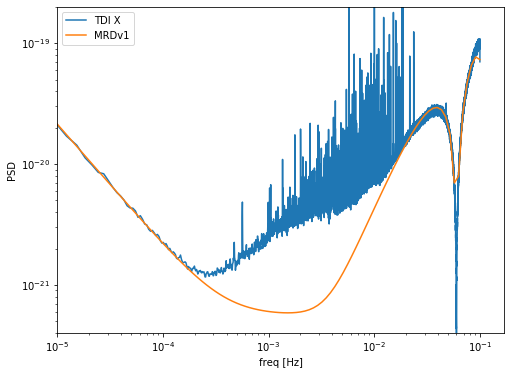

In [3]:
noise_model = "MRDv1"
Nmodel = get_noise_model(noise_model, np.logspace(-5, -1, 100))
Npsd = Nmodel.psd()

plt.figure(figsize=(8,6))
f, psdX =  scipy.signal.welch(tdi["X"], fs=1.0/dt, window='hanning', nperseg=256*256)
plt.loglog(f, np.sqrt(psdX), label="TDI X")
plt.loglog(Nmodel.freq, np.sqrt(Npsd), label=noise_model, alpha=2)
plt.legend()
plt.xlabel("freq [Hz]")
plt.ylabel("PSD")
plt.axis([1e-5, None, 4e-22, 2e-19])

In [4]:
tdi_ts = dict()
tdi_fs = dict()
for k in ["X", "Y", "Z"]:
    tdi_ts[k] = TimeSeries(tdi[k], dt=dt)
    tdi_fs[k] = tdi_ts[k].ts.fft(win=window)

Text(0.5, 0, 'freq [Hz]')

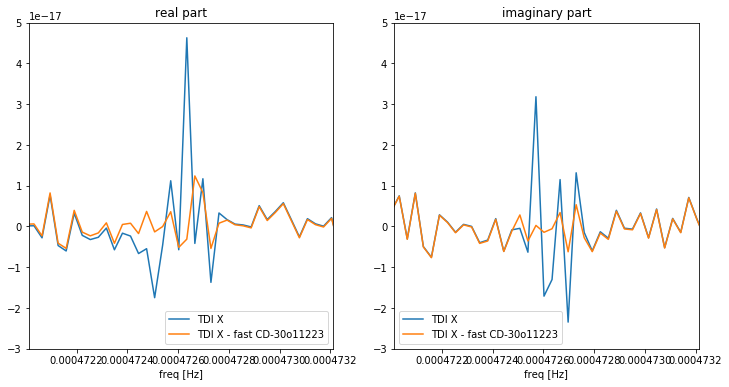

In [5]:
vgb = hdfio.load_array(sangria_fn, name="sky/vgb/cat", full_output=False)
GB = fastGB.FastGB(delta_t=dt, T=t_max) # in seconds
pGB = dict(zip(vgb.dtype.names, vgb[8]))
Xs, Ys, Zs = GB.get_fd_tdixyz(template=pGB, oversample=4, simulator='synthlisa')

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title("real part")
plt.plot(tdi_fs["X"].f, tdi_fs["X"].real, label="TDI X")
plt.plot(Xs.f, (tdi_fs["X"]-Xs).real, label="TDI X - fast "+pGB["Name"])
plt.axis([pGB["Frequency"]-6e-7, pGB["Frequency"]+6e-7, -3e-17, 5e-17])
plt.legend(loc="lower right")
plt.xlabel("freq [Hz]")
plt.subplot(122)
plt.title("imaginary part")
plt.plot(tdi_fs["X"].f, tdi_fs["X"].imag, label="TDI X")
plt.plot(Xs.f, (tdi_fs["X"]-Xs).imag, label="TDI X - fast "+pGB["Name"])
plt.axis([pGB["Frequency"]-6e-7, pGB["Frequency"]+6e-7, -3e-17, 5e-17])
plt.legend(loc="lower left")
plt.xlabel("freq [Hz]")

Text(0.5, 0, 'time [s]')

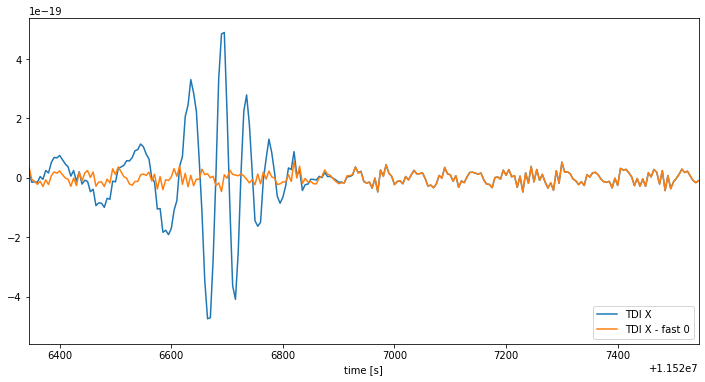

In [6]:
def semi_fast_tdi(config, pMBHB, t_max, dt):
    hphc = HpHc.type("MBHB-%d"%s_index, "MBHB", "IMRPhenomD")
    hphc.set_param(pMBHB)
    orbits = Orbits.type(config)
    P = ProjectedStrain(orbits)    
    yArm = P.arm_response(0, t_max, dt, [hphc], tt_order=1)
    X = P.compute_tdi_x(np.arange(0, t_max, dt))
    return TimeSeries(X, dt=dt)
  
mbhb = hdfio.load_array(sangria_fn, name="sky/mbhb/cat", full_output=False)
config = hdfio.load_config(sangria_fn, name="obs/config")
s_index = 0
pMBHB = dict(zip(mbhb.dtype.names, mbhb[s_index]))
Xs = semi_fast_tdi(config, pMBHB, t_max, dt)

plt.figure(figsize=(12,6))
plt.plot(tdi_ts["X"].t, tdi_ts["X"], label="TDI X")
plt.plot(Xs.t, (tdi_ts["X"]-Xs), label="TDI X - fast %d"%s_index)
plt.axis([pMBHB["CoalescenceTime"]-600, pMBHB["CoalescenceTime"]+600, None, None])
plt.legend(loc="lower right")
plt.xlabel("time [s]")

In [7]:
len(tdi_ts["X"])

6307201

In [8]:
vgb = hdfio.load_array(sangria_fn, name="sky/vgb/cat", full_output=False)
GB = fastGB.FastGB(delta_t=dt, T=t_max) # in seconds
noise_model = "MRDv1"
Nmodel = get_noise_model(noise_model, np.logspace(-5, -1, 100))
SNR2 = np.zeros((len(vgb), 2)) 
for j,s in enumerate(vgb):
    pGB = dict(zip(vgb.dtype.names, s))
    Xs, Ys, Zs = GB.get_fd_tdixyz(template=pGB, oversample=4, simulator='synthlisa')
    fmin, fmax = float(Xs.f[0]) , float(Xs.f[-1])
    source = dict({"X":Xs, "Y":Ys, "Z":Zs})
    SNR2[j,1] = compute_tdi_snr(source, Nmodel, data=tdi_fs, fmin=fmin, fmax=fmax)["tot2"]
    SNR2[j,0] = compute_tdi_snr(source, Nmodel)["tot2"]

In [9]:
import pandas as pd
data = np.array([vgb["Name"], vgb["Frequency"], SNR2[:,0], SNR2[:,1]]).T
pd.DataFrame(data, columns=["Name", "f0", "fastGB", "TDI"])

,Name,f0,fastGB,TDI
0,V407_Vul,0.0035125,294.61255381184463,482.1218043803042
1,SDSS_J135154.46,0.002119003220884896,665.3471877354668,678.4839308487402
2,AM_CVn,0.00194414,9477.091176696782,9186.05858752683
3,SDSS_J190817.07+394036.4,0.0018421295017039697,907.4603866650483,918.0190211317463
4,ZTF_J153932.16+502738.8,0.004821699107149872,3933.089356928894,3787.2149592230703
5,CR_Boo,0.00135962,6243.7101915557505,5954.294826329262
6,SDSS_J093506.92+441107.0,0.00166667,238.67880526710226,204.12256042975903
7,PTF1_J191905.19+481506.2,0.0014843952944669167,35.84377656754102,53.03250979244361
8,CD-30o11223,0.000472612,2074.2241631271936,2005.3195735437953
9,SDSS_J092345.59+302805.0,0.0005149728351829441,30.90247329550382,31.633333335170683


In [26]:
def mldc_fast_tdi(pMBHB, t_max, dt):
    from GenerateFD_SignalTDIs import ComputeMBHBXYZ_FD
    from LISAhdf5 import ParsUnits
    hphc = HpHc.type("MBHB-%d"%s_index, "MBHB", "IMRPhenomD")
    hphc.set_param(pMBHB)
    pMBHB["Cadence"] = dt
    pMBHB["ObservationDuration"] = t_max/2
    pu = ParsUnits(pars_i=pMBHB, units_i=hphc.info())
    fr, Xs, Ys, Zs = ComputeMBHBXYZ_FD(pu)
    return (FrequencySeries(Xs, df=1/t_max), 
            FrequencySeries(Ys, df=1/t_max),
            FrequencySeries(Zs, df=1/t_max))

mbhb = hdfio.load_array(sangria_fn, name="sky/mbhb/cat", full_output=False)
config = hdfio.load_config(sangria_fn, name="obs/config")
noise_model = "MRDv1"
Nmodel = get_noise_model(noise_model, np.logspace(-5, -1, 100))
SNR2 = np.zeros((len(mbhb), 2)) 
for j,s in enumerate(mbhb):
    print(j)
    pMBHB = dict(zip(mbhb.dtype.names, s))
    Xs,Ys,Zs = mldc_fast_tdi(pMBHB, t_max, dt)
    source = dict({"X":Xs, "Y":Ys, "Z":Zs})
    SNR2[j,1] = compute_tdi_snr(source, Nmodel, data=tdi_fs)["tot2"]
    SNR2[j,0] = compute_tdi_snr(source, Nmodel)["tot2"]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [30]:
import pandas as pd
data = np.array([range(len(mbhb)), mbhb["CoalescenceTime"], SNR2[:,0], SNR2[:,1]]).T
pd.DataFrame(data, columns=["index", "tc", "fast", "TDI"])

,index,tc,fast,TDI
0,0.0,1.152694e+07,2.645716e+06,1.220424e+06
1,1.0,1.125857e+07,1.395930e+06,-4.458204e+05
2,2.0,1.653219e+07,5.906129e+04,3.792859e+04
3,3.0,2.951609e+07,9.635132e+04,-1.466793e+04
4,4.0,1.860576e+07,1.135225e+05,7.342962e+04
5,5.0,1.116784e+07,1.183450e+04,4.308468e+03
6,6.0,8.746488e+06,2.637877e+04,-1.779625e+04
7,7.0,1.724516e+07,2.373035e+05,7.278444e+04
8,8.0,2.440876e+07,6.858175e+04,-3.664405e+04
9,9.0,2.042622e+07,4.208860e+05,-4.015123e+05
